In [0]:
# for mounting drive with google colabs
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install -q keras

In [247]:
!ls

datalab  drive	logs


In [0]:
import sys
import time 
import os
import cv2
import datetime
from PIL import Image
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
% matplotlib inline

# Reading data

In [0]:
data = pd.read_csv('drive/fer2013.csv')

In [250]:
data['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [0]:
data_train = data.loc[data['Usage']=='Training']
public_test = data.loc[data['Usage']=='PublicTest']
private_test = data.loc[data['Usage']=='PrivateTest']

In [252]:
data_train.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [253]:
public_test.head()

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [254]:
private_test.head()

,emotion,pixels,Usage
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest


In [255]:
data_train.describe()

,emotion
count,28709.000000
mean,3.317427
std,1.876632
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [0]:
k = data_train.iloc[1,1]

In [257]:
len(k.split())

2304

# Data Preprocessing
## Transforming csv to understandable image data

In [0]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)
public_test = shuffle(public_test)
private_test = shuffle(private_test)

In [259]:
train = np.array(data_train.iloc[:,1])
validation = np.array(private_test.iloc[:,1])
test = np.array(public_test.iloc[:,1])
print(train.shape, test.shape, validation.shape)

(28709,) (3589,) (3589,)


In [0]:
train = train.reshape(28709,1)
test = test.reshape(3589,1)
validation = validation.reshape(3589,1)
X_train_flip = list()

In [261]:
train.shape

(28709, 1)

In [0]:
def data_augmentation(img):
  img = cv2.flip(img.reshape(48,48), 1)
  return np.array(img.reshape(48,48,1)).astype(np.float32)

In [0]:
def reform_data_aug(img_str):
  t1 = img_str[0].split()
  t2 = np.array(t1).astype(np.float32)
  t3 = t2.reshape(48, 48, 1)

  X_train_flip.append(data_augmentation(t3))
  return t3

In [0]:
def reform_data(img_str):
  t1 = img_str[0].split()
  t2 = np.array(t1).astype(np.float32)
  t3 = t2.reshape(48, 48, 1)
  return t3

In [0]:
X_train_1 = np.apply_along_axis(reform_data_aug, 1, train)
X_test = np.apply_along_axis(reform_data, 1, test)
X_validation = np.apply_along_axis(reform_data, 1, validation)

In [266]:
np.array(X_train_flip).shape

(28709, 48, 48, 1)

In [267]:
X_train = np.array(list(X_train_1) + X_train_flip)
print(X_train.shape)

(57418, 48, 48, 1)


In [268]:
print(X_train.shape, X_test.shape, X_validation.shape)

(57418, 48, 48, 1) (3589, 48, 48, 1) (3589, 48, 48, 1)


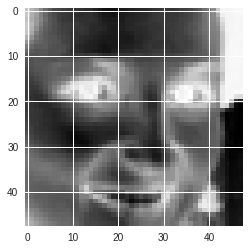

In [269]:
# Sample image
plt.imshow(X_train[0].reshape(48,48))

### Normalization 

In [0]:
X_train = X_train/255
X_test = X_test/255
X_validation = X_validation/255

### One Hot Encoding

In [0]:
Y_train = data_train['emotion']
Y_test = public_test['emotion']
Y_validation = private_test['emotion']

In [272]:
print(Y_train.shape, Y_test.shape, Y_validation.shape)

(28709,) (3589,) (3589,)


In [0]:
def onehot(Y, C):
  Y = np.eye(C)[Y].T
  return Y

In [274]:
data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [0]:
Y_test = onehot(Y_test, 7).T
Y_train = onehot(Y_train, 7).T
Y_valid = onehot(Y_validation, 7).T

In [276]:
Y_train.shape

(28709, 7)

In [0]:
Y_train = np.array(list(Y_train) + list(Y_train))

In [278]:
Y_train.shape

(57418, 7)

In [0]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=2)

In [280]:
print(X_validation.shape, Y_valid.shape)

(3589, 48, 48, 1) (3589, 7)


In [0]:
# Clear memory
del data
del data_train
del public_test
del private_test
del Y_validation

## CNN Models
Taking 3 - 4 models for ensemble voting

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model

### 1-Basic 5 layer model

In [0]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
input_shape = (48, 48, 1)

In [0]:
def Model1(input_shape=(48,48,1)):
  model = Sequential()
  
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=input_shape, data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(num_labels, activation='softmax'))
  return model

In [285]:
model1 = Model1()
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_42 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_43 (Batc (None, 23, 23, 128)       512       
__________

In [0]:
model1.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard = TensorBoard(log_dir='./logs')
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [293]:
model1.fit(X_train,Y_train,
          batch_size=batch_size,
          epochs=300,
          verbose=1,
          validation_data=(X_validation, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, tensorboard, checkpointer])

Train on 57418 samples, validate on 3589 samples
Epoch 1/300
43904/57418 [=====================>........] - ETA: 27s - loss: 0.2608 - acc: 0.9122

57418/57418 [==============================] - 119s 2ms/step - loss: 0.2594 - acc: 0.9127 - val_loss: 1.4411 - val_acc: 0.6726

Epoch 00001: val_loss did not improve from 1.04537
Epoch 2/300
19008/57418 [========>.....................] - ETA: 1:17 - loss: 0.2587 - acc: 0.9120

57418/57418 [==============================] - 119s 2ms/step - loss: 0.2579 - acc: 0.9130 - val_loss: 1.3729 - val_acc: 0.6734

Epoch 00002: val_loss did not improve from 1.04537
Epoch 3/300
11392/57418 [====>.........................] - ETA: 1:33 - loss: 0.2479 - acc: 0.9153

57418/57418 [==============================] - 119s 2ms/step - loss: 0.2482 - acc: 0.9162 - val_loss: 1.3674 - val_acc: 0.6709

Epoch 00003: val_loss did not improve from 1.04537
Epoch 4/300
 9088/57418 [===>..........................] - ETA: 1:38 - loss: 0.2546 - acc: 0.9141

57418/57418 [==============================] - 119s 2ms/step - loss: 0.2530 - acc: 0.9152 - val_loss: 1.4244 - val_acc: 0.6670

Epoch 00004: val_loss did not improve from 1.04537
Epoch 5/300
 8320/57418 [===>..........................] - ETA: 1:39 - loss: 0.2442 - acc: 0.9185

57418/57418 [==============================] - 119s 2ms/step - loss: 0.2460 - acc: 0.9162 - val_loss: 1.4269 - val_acc: 0.6718

Epoch 00005: val_loss did not improve from 1.04537
Epoch 6/300
 8128/57418 [===>..........................] - ETA: 1:39 - loss: 0.2484 - acc: 0.9158

57418/57418 [==============================] - 119s 2ms/step - loss: 0.2414 - acc: 0.9187 - val_loss: 1.4125 - val_acc: 0.6746

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00022876793809700757.

Epoch 00006: val_loss did not improve from 1.04537
Epoch 7/300
 6208/57418 [==>...........................] - ETA: 1:44 - loss: 0.2216 - acc: 0.9240

57418/57418 [==============================] - 119s 2ms/step - loss: 0.2381 - acc: 0.9206 - val_loss: 1.3964 - val_acc: 0.6701

Epoch 00007: val_loss did not improve from 1.04537
Epoch 8/300
 7488/57418 [==>...........................] - ETA: 1:41 - loss: 0.2435 - acc: 0.9224

57418/57418 [==============================] - 118s 2ms/step - loss: 0.2401 - acc: 0.9192 - val_loss: 1.3981 - val_acc: 0.6707

Epoch 00008: val_loss did not improve from 1.04537
Epoch 9/300
 7872/57418 [===>..........................] - ETA: 1:39 - loss: 0.2325 - acc: 0.9243

57418/57418 [==============================] - 118s 2ms/step - loss: 0.2316 - acc: 0.9227 - val_loss: 1.4417 - val_acc: 0.6679

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00020589114428730683.

Epoch 00009: val_loss did not improve from 1.04537
Epoch 10/300
 6144/57418 [==>...........................] - ETA: 1:43 - loss: 0.2311 - acc: 0.9207

57418/57418 [==============================] - 118s 2ms/step - loss: 0.2324 - acc: 0.9217 - val_loss: 1.4222 - val_acc: 0.6701

Epoch 00010: val_loss did not improve from 1.04537
Epoch 11/300
 7424/57418 [==>...........................] - ETA: 1:41 - loss: 0.2218 - acc: 0.9263

57418/57418 [==============================] - 118s 2ms/step - loss: 0.2273 - acc: 0.9240 - val_loss: 1.4427 - val_acc: 0.6670

Epoch 00011: val_loss did not improve from 1.04537
Epoch 00011: early stopping


In [0]:
model1.save_weights("drive/face_expr_model1.h5")

In [295]:
model1.evaluate(X_test, Y_test, batch_size=batch_size)


3589/3589 [==============================] - 3s 711us/step


[1.4634044743009382, 0.6753970465393709]

### 2- Model2 - https://arxiv.org/pdf/1706.01509

In [0]:
def Model2(input_shape=(48,48,1)):
  model = Sequential()
  model.add(Conv2D(10, (5,5), activation='relu', kernel_regularizer=l2(0.01), input_shape=input_shape))
  model.add(AveragePooling2D())
#   model.add(Dropout(0.5))
  model.add(Conv2D(10, (5,5), activation='relu'))
  model.add(MaxPooling2D())
#   model.add(Dropout(0.5))
  model.add(Conv2D(10, (3,3), activation='relu'))
  model.add(MaxPooling2D()) 
#   model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_labels, activation='softmax'))
  return model

In [311]:
model2 = Model2()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 44, 44, 10)        260       
_________________________________________________________________
average_pooling2d_3 (Average (None, 22, 22, 10)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 18, 18, 10)        2510      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 9, 9, 10)          0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 7, 7, 10)          910       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 3, 3, 10)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 90)                0         
__________

In [0]:
lr_reducer2 = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard2 = TensorBoard(log_dir='./logs')
early_stopper2 = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer2 = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model2.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
model2.fit(X_train,Y_train,
          batch_size=batch_size,
          epochs=300,
          verbose=1,
          validation_data=(X_validation, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer2, tensorboard2, checkpointer2])

Train on 57418 samples, validate on 3589 samples
Epoch 1/300
57418/57418 [==============================] - 15s 264us/step - loss: 1.2001 - acc: 0.5469 - val_loss: 1.2693 - val_acc: 0.5227

Epoch 00001: val_loss improved from 1.27113 to 1.26925, saving model to /drive
Epoch 2/300
38592/57418 [===================>..........] - ETA: 4s - loss: 1.1974 - acc: 0.5461

57418/57418 [==============================] - 15s 264us/step - loss: 1.1992 - acc: 0.5454 - val_loss: 1.2786 - val_acc: 0.5216

Epoch 00002: val_loss did not improve from 1.26925
Epoch 3/300
57418/57418 [==============================] - 15s 263us/step - loss: 1.1937 - acc: 0.5483 - val_loss: 1.2761 - val_acc: 0.5196

Epoch 00003: val_loss did not improve from 1.26925
Epoch 4/300
10944/57418 [====>.........................] - ETA: 12s - loss: 1.1948 - acc: 0.5461

57418/57418 [==============================] - 15s 262us/step - loss: 1.1979 - acc: 0.5471 - val_loss: 1.2727 - val_acc: 0.5224

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00047829695977270604.

Epoch 00004: val_loss did not improve from 1.26925
Epoch 5/300
52096/57418 [==========================>...] - ETA: 1s - loss: 1.1905 - acc: 0.5468

57418/57418 [==============================] - 15s 263us/step - loss: 1.1932 - acc: 0.5459 - val_loss: 1.2748 - val_acc: 0.5160

Epoch 00005: val_loss did not improve from 1.26925
Epoch 6/300
57418/57418 [==============================] - 15s 268us/step - loss: 1.1957 - acc: 0.5495 - val_loss: 1.2717 - val_acc: 0.5227

Epoch 00006: val_loss did not improve from 1.26925
Epoch 7/300
11712/57418 [=====>........................] - ETA: 11s - loss: 1.1835 - acc: 0.5591

57418/57418 [==============================] - 15s 264us/step - loss: 1.1926 - acc: 0.5491 - val_loss: 1.2661 - val_acc: 0.5272

Epoch 00007: val_loss improved from 1.26925 to 1.26607, saving model to /drive
Epoch 8/300
57418/57418 [==============================] - 15s 263us/step - loss: 1.1892 - acc: 0.5492 - val_loss: 1.2694 - val_acc: 0.5213

Epoch 00008: val_loss did not improve from 1.26607
Epoch 9/300
 2944/57418 [>.............................] - ETA: 13s - loss: 1.1686 - acc: 0.5622

57418/57418 [==============================] - 15s 262us/step - loss: 1.1934 - acc: 0.5477 - val_loss: 1.2621 - val_acc: 0.5252

Epoch 00009: val_loss improved from 1.26607 to 1.26210, saving model to /drive
Epoch 10/300
57418/57418 [==============================] - 15s 263us/step - loss: 1.1877 - acc: 0.5490 - val_loss: 1.2715 - val_acc: 0.5213

Epoch 00010: val_loss did not improve from 1.26210
Epoch 11/300
 1280/57418 [..............................] - ETA: 14s - loss: 1.1811 - acc: 0.5539

57418/57418 [==============================] - 15s 262us/step - loss: 1.1837 - acc: 0.5518 - val_loss: 1.2688 - val_acc: 0.5261

Epoch 00011: val_loss did not improve from 1.26210
Epoch 12/300
57418/57418 [==============================] - 15s 263us/step - loss: 1.1874 - acc: 0.5486 - val_loss: 1.2727 - val_acc: 0.5244

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0004304672533180565.

Epoch 00012: val_loss did not improve from 1.26210
Epoch 13/300
 3520/57418 [>.............................] - ETA: 14s - loss: 1.1722 - acc: 0.5489

57418/57418 [==============================] - 15s 262us/step - loss: 1.1839 - acc: 0.5499 - val_loss: 1.2738 - val_acc: 0.5180

Epoch 00013: val_loss did not improve from 1.26210
Epoch 14/300
57418/57418 [==============================] - 15s 265us/step - loss: 1.1780 - acc: 0.5520 - val_loss: 1.2707 - val_acc: 0.5247

Epoch 00014: val_loss did not improve from 1.26210
Epoch 15/300
 4096/57418 [=>............................] - ETA: 13s - loss: 1.1727 - acc: 0.5498

57418/57418 [==============================] - 15s 265us/step - loss: 1.1772 - acc: 0.5523 - val_loss: 1.2685 - val_acc: 0.5249

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00038742052274756136.

Epoch 00015: val_loss did not improve from 1.26210
Epoch 16/300
51648/57418 [=========================>....] - ETA: 1s - loss: 1.1743 - acc: 0.5540

57418/57418 [==============================] - 15s 263us/step - loss: 1.1742 - acc: 0.5541 - val_loss: 1.2645 - val_acc: 0.5247

Epoch 00016: val_loss did not improve from 1.26210
Epoch 17/300
57418/57418 [==============================] - 15s 263us/step - loss: 1.1711 - acc: 0.5542 - val_loss: 1.2699 - val_acc: 0.5216

Epoch 00017: val_loss did not improve from 1.26210
Epoch 18/300
13440/57418 [======>.......................] - ETA: 11s - loss: 1.1513 - acc: 0.5667

57418/57418 [==============================] - 15s 263us/step - loss: 1.1730 - acc: 0.5560 - val_loss: 1.2714 - val_acc: 0.5222

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0003486784757114947.

Epoch 00018: val_loss did not improve from 1.26210
Epoch 19/300
53376/57418 [==========================>...] - ETA: 1s - loss: 1.1691 - acc: 0.5583

57418/57418 [==============================] - 15s 263us/step - loss: 1.1697 - acc: 0.5579 - val_loss: 1.2670 - val_acc: 0.5188

Epoch 00019: val_loss did not improve from 1.26210
Epoch 20/300
57418/57418 [==============================] - 15s 261us/step - loss: 1.1706 - acc: 0.5559 - val_loss: 1.2680 - val_acc: 0.5235

Epoch 00020: val_loss did not improve from 1.26210
Epoch 21/300
14016/57418 [======>.......................] - ETA: 11s - loss: 1.1596 - acc: 0.5611

57418/57418 [==============================] - 15s 266us/step - loss: 1.1651 - acc: 0.5599 - val_loss: 1.2708 - val_acc: 0.5166

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.00031381062290165574.

Epoch 00021: val_loss did not improve from 1.26210
Epoch 22/300
52480/57418 [==========================>...] - ETA: 1s - loss: 1.1629 - acc: 0.5608

57418/57418 [==============================] - 15s 264us/step - loss: 1.1638 - acc: 0.5601 - val_loss: 1.2663 - val_acc: 0.5277

Epoch 00022: val_loss did not improve from 1.26210
Epoch 23/300
57418/57418 [==============================] - 15s 263us/step - loss: 1.1625 - acc: 0.5597 - val_loss: 1.2584 - val_acc: 0.5272

Epoch 00023: val_loss improved from 1.26210 to 1.25839, saving model to /drive
Epoch 24/300
11904/57418 [=====>........................] - ETA: 11s - loss: 1.1510 - acc: 0.5617

57418/57418 [==============================] - 15s 265us/step - loss: 1.1625 - acc: 0.5585 - val_loss: 1.2562 - val_acc: 0.5263

Epoch 00024: val_loss improved from 1.25839 to 1.25616, saving model to /drive
Epoch 25/300
57418/57418 [==============================] - 15s 260us/step - loss: 1.1601 - acc: 0.5579 - val_loss: 1.2714 - val_acc: 0.5216

Epoch 00025: val_loss did not improve from 1.25616
Epoch 26/300
 3328/57418 [>.............................] - ETA: 13s - loss: 1.1667 - acc: 0.5679

57418/57418 [==============================] - 15s 259us/step - loss: 1.1619 - acc: 0.5585 - val_loss: 1.2673 - val_acc: 0.5288

Epoch 00026: val_loss did not improve from 1.25616
Epoch 27/300
57418/57418 [==============================] - 15s 262us/step - loss: 1.1582 - acc: 0.5601 - val_loss: 1.2688 - val_acc: 0.5216

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0002824295632308349.

Epoch 00027: val_loss did not improve from 1.25616
Epoch 28/300
 4480/57418 [=>............................] - ETA: 13s - loss: 1.1383 - acc: 0.5661

57418/57418 [==============================] - 15s 261us/step - loss: 1.1564 - acc: 0.5587 - val_loss: 1.2692 - val_acc: 0.5169

Epoch 00028: val_loss did not improve from 1.25616
Epoch 29/300
57418/57418 [==============================] - 15s 261us/step - loss: 1.1593 - acc: 0.5610 - val_loss: 1.2685 - val_acc: 0.5216

Epoch 00029: val_loss did not improve from 1.25616
Epoch 30/300
 5760/57418 [==>...........................] - ETA: 13s - loss: 1.1407 - acc: 0.5613

57418/57418 [==============================] - 15s 261us/step - loss: 1.1541 - acc: 0.5611 - val_loss: 1.2685 - val_acc: 0.5188

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00025418660952709616.

Epoch 00030: val_loss did not improve from 1.25616
Epoch 31/300
51840/57418 [==========================>...] - ETA: 1s - loss: 1.1497 - acc: 0.5634

57418/57418 [==============================] - 15s 263us/step - loss: 1.1517 - acc: 0.5626 - val_loss: 1.2694 - val_acc: 0.5132

Epoch 00031: val_loss did not improve from 1.25616
Epoch 32/300
 1280/57418 [..............................] - ETA: 14s - loss: 1.0843 - acc: 0.5742

In [0]:
model2.save_weights("drive/face_expr_model2.h5")

In [317]:
model2.evaluate(X_test, Y_test, batch_size=batch_size)

3589/3589 [==============================] - 0s 82us/step


[1.2768794384531472, 0.5151852883894684]